## Setup

In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
import math

In [2]:
# Import data
tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_train_set_no_zeros.csv")


# Quick inspection
tor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8308 entries, 0 to 8307
Data columns (total 35 columns):
DAMAGE_PROPERTY       8308 non-null float64
DURATION_SECONDS      8308 non-null float64
BEGIN_LAT             8308 non-null float64
BEGIN_LON             8308 non-null float64
TOR_LENGTH            8308 non-null float64
TOR_WIDTH             8308 non-null float64
YEAR                  8308 non-null float64
MULTI_VORT_IND        8308 non-null int64
OPEN_WATER_PROP       8308 non-null float64
DEV_OPEN_PROP         8308 non-null float64
DEV_LOW_PROP          8308 non-null float64
DEV_MED_PROP          8308 non-null float64
DEV_HIGH_PROP         8308 non-null float64
BARREN_LAND_PROP      8308 non-null float64
DECID_FOREST_PROP     8308 non-null float64
EVERGR_FOREST_PROP    8308 non-null float64
MIXED_FOREST_PROP     8308 non-null float64
SHRUB_SCRUB_PROP      8308 non-null float64
GRASS_LAND_PROP       8308 non-null float64
PASTURE_HAY_PROP      8308 non-null float64
CULT_CROPS_PROP

In [3]:
# Seperating variables
# The dependent variables
tornado_outcomes = tor_df.iloc[:, [0]]


# Quick inspection
tornado_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8308 entries, 0 to 8307
Data columns (total 1 columns):
DAMAGE_PROPERTY    8308 non-null float64
dtypes: float64(1)
memory usage: 65.0 KB


In [4]:
# The independent variables
tornado_features = tor_df.loc[:, ["DURATION_SECONDS",
                                  "TOR_LENGTH",
                                  "TOR_WIDTH",
                                  "YEAR",
                                  "MULTI_VORT_IND",
                                  "TOR_AREA",
                                  "DAY_OF_YEAR",
                                  "MONTH",
                                  "TIME"]]


# Quick inspection
tornado_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8308 entries, 0 to 8307
Data columns (total 9 columns):
DURATION_SECONDS    8308 non-null float64
TOR_LENGTH          8308 non-null float64
TOR_WIDTH           8308 non-null float64
YEAR                8308 non-null float64
MULTI_VORT_IND      8308 non-null int64
TOR_AREA            8308 non-null float64
DAY_OF_YEAR         8308 non-null float64
MONTH               8308 non-null float64
TIME                8308 non-null float64
dtypes: float64(8), int64(1)
memory usage: 584.2 KB


In [5]:
# Make the dependent variables into a numpy array
outcomes_array = tornado_outcomes.values


# Makes the numpy array into a torch Tensor
outcomes_Tensor = torch.from_numpy(outcomes_array)


# Quick inspection
outcomes_Tensor


 0.1532
 0.6540
 0.0873
   ⋮    
 0.5790
 0.1532
 0.2814
[torch.DoubleTensor of size 8308x1]

In [6]:
# Make the independent variables into a numpy array
features_array = tornado_features.values


# Make the numpy array into a torch Tensor
features_Tensor = torch.from_numpy(features_array)


# Quick inspection
features_Tensor


 0.0227 -0.4127 -0.7859  ...  -0.0068 -0.2947 -0.4531
-0.3046 -1.0358 -0.9368  ...  -0.1143 -0.2947  1.1092
 0.3520  0.0818 -0.9368  ...  -0.9653 -1.0297 -0.1038
          ...             ⋱             ...          
 0.5451  0.6778 -0.3589  ...  -0.7735 -1.0297 -1.5301
 0.0227 -0.4127 -0.7859  ...   0.8091  0.8078 -2.1918
 0.4583  0.9771 -0.3589  ...  -2.1091 -1.7647  0.5064
[torch.DoubleTensor of size 8308x9]

### Convert DoubleTensor to FloatTensor

In [7]:
# Changing dependent variables from a DoubleTensor to a FloatTensor
outcomes_Tensor = outcomes_Tensor.float()


# ...and for the independent variables
features_Tensor = features_Tensor.float()


# Quick check
features_Tensor


 0.0227 -0.4127 -0.7859  ...  -0.0068 -0.2947 -0.4531
-0.3046 -1.0358 -0.9368  ...  -0.1143 -0.2947  1.1092
 0.3520  0.0818 -0.9368  ...  -0.9653 -1.0297 -0.1038
          ...             ⋱             ...          
 0.5451  0.6778 -0.3589  ...  -0.7735 -1.0297 -1.5301
 0.0227 -0.4127 -0.7859  ...   0.8091  0.8078 -2.1918
 0.4583  0.9771 -0.3589  ...  -2.1091 -1.7647  0.5064
[torch.FloatTensor of size 8308x9]

## Round 1: One-Hidden-Layer Neural Network

In [8]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [9]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 1))

In [10]:
# Set the loss function
loss_fn = torch.nn.MSELoss(size_average=False)

In [11]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

In [12]:
# Get the iterations
iterations = list(range(0, 10000))

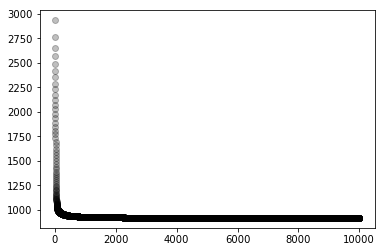

In [13]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [14]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

In [15]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
outcomes_Variable_resized = outcomes_Variable.resize(8308)


# Make the FloatTensor into a numpy.array
outcomes_array = outcomes_Variable_resized.data.numpy()


# Make the numpy.array into a list
outcomes_list = outcomes_array.tolist()

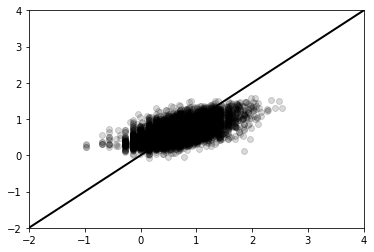

In [16]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 1.1: Validation Set Performance

In [17]:
# Import data
valid_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_cv_set_no_zeros.csv")


# Validation set outcomes
valid_outcomes = valid_df.iloc[:, [0]]


# Make the validation outcomes into a numpy array
valid_outcomes_array = valid_outcomes.values


# Makes the numpy array into a torch Tensor
valid_outcomes_Tensor = torch.from_numpy(valid_outcomes_array)


# Changing validation outcomes from a DoubleTensor to a FloatTensor
valid_outcomes_Tensor = valid_outcomes_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_outcomes_Variable = Variable(valid_outcomes_Tensor)


# Quick check
valid_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2808 entries, 0 to 2807
Data columns (total 1 columns):
DAMAGE_PROPERTY    2808 non-null float64
dtypes: float64(1)
memory usage: 22.0 KB


In [18]:
# Validation set predictors
valid_predictors = valid_df.loc[:, ["DURATION_SECONDS",
                                    "TOR_LENGTH",
                                    "TOR_WIDTH",
                                    "YEAR",
                                    "MULTI_VORT_IND",
                                    "TOR_AREA",
                                    "DAY_OF_YEAR",
                                    "MONTH",
                                   "TIME"]]


# Make the validation predictors into a numpy array
valid_predictors_array = valid_predictors.values


# Makes the numpy array into a torch Tensor
valid_predictors_Tensor = torch.from_numpy(valid_predictors_array)


# Changing validation predictors from a DoubleTensor to a FloatTensor
valid_predictors_Tensor = valid_predictors_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_predictors_Variable = Variable(valid_predictors_Tensor)


# Quick check
valid_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2808 entries, 0 to 2807
Data columns (total 9 columns):
DURATION_SECONDS    2808 non-null float64
TOR_LENGTH          2808 non-null float64
TOR_WIDTH           2808 non-null float64
YEAR                2808 non-null float64
MULTI_VORT_IND      2808 non-null int64
TOR_AREA            2808 non-null float64
DAY_OF_YEAR         2808 non-null float64
MONTH               2808 non-null float64
TIME                2808 non-null float64
dtypes: float64(8), int64(1)
memory usage: 197.5 KB


In [19]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 307.2168
[torch.FloatTensor of size 1]

In [20]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

In [21]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
valid_outcomes_Variable_resized = valid_outcomes_Variable.resize(2808)


# Make the FloatTensor into a numpy.array
valid_outcomes_array = valid_outcomes_Variable_resized.data.numpy()


# Convert back to log scale
valid_outcomes_array = valid_outcomes_array*5.407597 + 7.688844


# Make the numpy.array into a list
valid_outcomes_list = valid_outcomes_array.tolist()

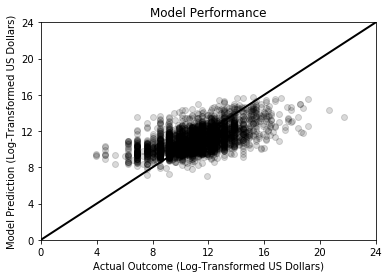

In [22]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [23]:
model[(0)].weight

Parameter containing:
-0.2618  0.3943  0.1703 -0.2453 -0.5271 -0.2625 -0.5457 -0.0833 -0.0346
-0.0574 -0.3172 -0.1462  0.3538  0.4823 -0.1232 -0.3257 -0.2613 -0.1338
 0.4317  0.1050  0.3800 -0.0551 -0.1196 -0.0987  0.0457  0.1436  0.0874
-0.2013 -0.1724 -0.1438  0.1793  0.4105 -0.2559 -0.4082 -0.1274 -0.1350
 0.0033  0.2115  0.2055 -0.1736  0.0446 -0.1674  0.0710  0.0366 -0.1701
 0.4016  0.1374  0.0827 -0.5355 -0.8865 -0.0958  0.0135  0.0548 -0.1973
[torch.FloatTensor of size 6x9]

In [24]:
model[(2)].weight

Parameter containing:
 0.2088  0.3505  0.4151 -0.5189  0.4859 -0.2325
[torch.FloatTensor of size 1x6]

## Round 2: Two-Hidden-Layer Neural Network

In [25]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [26]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 4),
                            torch.nn.ReLU(),
                            torch.nn.Linear(4, 1))

In [27]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

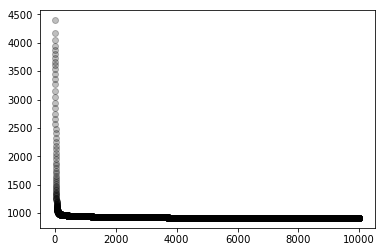

In [28]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [29]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

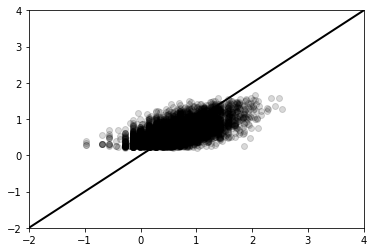

In [30]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 2.1: Validation Set Performance

In [31]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 304.5946
[torch.FloatTensor of size 1]

In [32]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

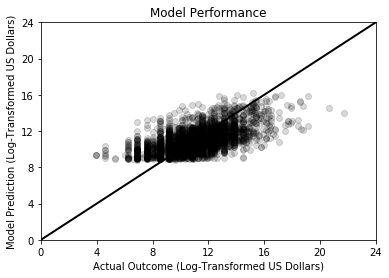

In [33]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [34]:
model[(0)].weight

Parameter containing:
-0.3241 -0.1484  0.4446  0.0918  0.7872  0.0020  0.1168 -0.0511  0.0398
 0.0899 -0.2484  0.2990 -0.1136 -0.0217  0.3284  0.0935 -0.0309  0.1604
 0.0961  0.2760  0.3801  0.0066 -0.2269  0.0568 -0.2468 -0.4594 -0.3759
-0.5971  0.4369  0.2084 -0.0920  0.6393  0.2559 -0.0618  0.1918 -0.1412
 0.3602  0.2550  0.1901  0.0137  0.1575  0.2759  0.0092  0.3300 -0.2245
 0.2237 -0.0174  0.0709  0.1094 -0.2049  0.2300 -0.0899 -0.1730  0.3367
[torch.FloatTensor of size 6x9]

In [35]:
model[(2)].weight

Parameter containing:
 0.1559 -0.3755 -0.4024 -0.2888  0.0179 -0.0825
 0.1148  0.0435 -0.2031  0.1118 -0.1482  0.0657
-0.1733  0.6172  0.2471  0.8368  0.2995 -0.0741
-0.4673  0.3669  0.1015  0.3960  0.1846  0.2784
[torch.FloatTensor of size 4x6]

In [36]:
model[(4)].weight

Parameter containing:
-0.3703  0.0236  0.1305  0.4154
[torch.FloatTensor of size 1x4]

## Round 3: Three-Hidden-Layer Neural Network

In [37]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [38]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 4),
                            torch.nn.ReLU(),
                            torch.nn.Linear(4, 3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(3, 1))

In [39]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

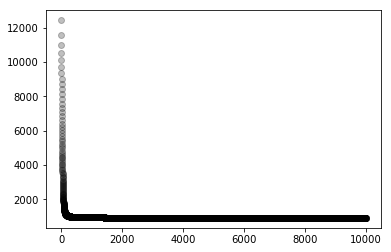

In [40]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [41]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

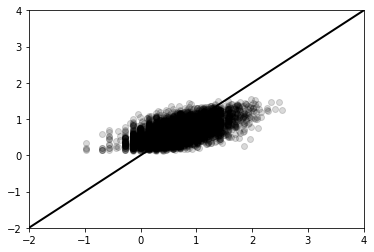

In [42]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 3.1: Validation Set Performance

In [43]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 306.0697
[torch.FloatTensor of size 1]

In [44]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

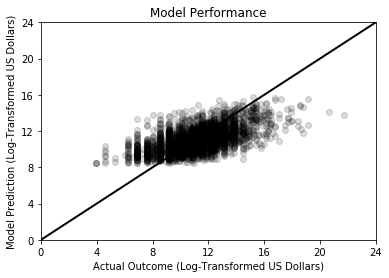

In [45]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [46]:
model[(0)].weight

Parameter containing:
-0.0591  0.1575 -0.0122  0.0631 -0.3339  0.0736  0.3117 -0.0316  0.4181
 0.3079  0.5088 -0.1749 -0.3953 -1.1488 -0.6766  0.0632  0.2208  0.0194
 0.0613  0.4166  0.0075 -0.3714  0.0203  0.1048 -0.0204  0.4051 -0.0505
 0.1208 -0.0151  0.2673 -0.0806  0.1635  0.1584  0.0005  0.0795  0.2892
 0.1661  0.0383  0.2483 -0.0410 -0.2698  0.3326  0.0650 -0.4299  0.3685
-0.0604  0.3071  0.3788  0.1392 -0.2546 -0.1870 -0.1200 -0.0847 -0.3948
[torch.FloatTensor of size 6x9]

In [47]:
model[(2)].weight

Parameter containing:
-0.2972 -0.4640  0.3280  0.3611  0.2277  0.4198
 0.3038  0.4666 -0.0247  0.2700  0.0076 -0.1343
 0.2362 -0.1591 -0.2458 -0.0593 -0.3568 -0.0473
-0.1471  0.1240  0.2676 -0.1222 -0.0151  0.0930
[torch.FloatTensor of size 4x6]

In [48]:
model[(4)].weight

Parameter containing:
-0.1656 -0.3440  0.3741 -0.3397
-0.3530  0.0037 -0.4892 -0.3362
 0.6638  0.1863 -0.0136  0.2287
[torch.FloatTensor of size 3x4]

In [49]:
model[(6)].weight

Parameter containing:
-0.4015 -0.1530  0.6911
[torch.FloatTensor of size 1x3]

## Round 4: Four-Hidden-Layer Neural Network

In [50]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [51]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 4),
                            torch.nn.ReLU(),
                            torch.nn.Linear(4, 3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(3, 2),
                            torch.nn.ReLU(),
                            torch.nn.Linear(2, 1))

In [52]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

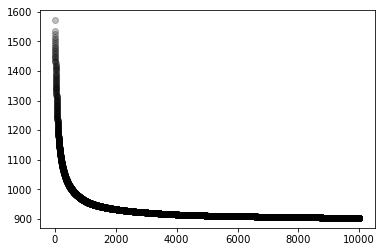

In [53]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [54]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

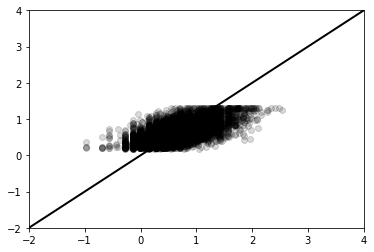

In [55]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 4.1: Validation Set Performance

In [56]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 304.1985
[torch.FloatTensor of size 1]

In [57]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

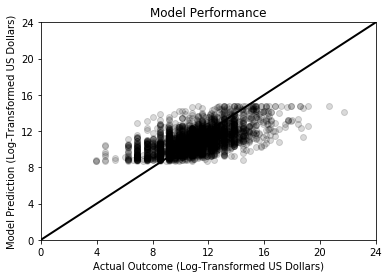

In [58]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [59]:
model[(0)].weight

Parameter containing:
-0.1636 -0.5669  0.2013 -0.2121  1.8691 -0.5541  0.0176 -0.1489 -0.2589
 0.4325 -0.0063  0.0562  0.1790  0.4887  0.2693  0.0926  0.0769  0.1535
 0.0999  0.3186  0.3690  0.0856 -0.1808 -0.4977 -0.0788 -0.1676  0.0408
-0.2870  0.1846  0.1273 -0.2386 -0.1803  0.4148  0.0493  0.1234 -0.2453
 0.1647 -0.2749  0.1437  0.5208 -0.2480  0.2056  0.5953 -0.6180  0.0907
-0.0160  0.2599 -0.2534  0.1392 -0.0269 -0.2357 -0.0345  0.0415  0.0454
[torch.FloatTensor of size 6x9]

In [60]:
model[(2)].weight

Parameter containing:
-0.1097  0.3283  0.0657  0.0816  0.2549 -0.6915
-0.1844  0.4886 -0.0909  0.6378  0.0486 -0.2028
-0.1621  0.0431  0.5628 -0.1173 -0.4357 -0.3999
 0.7322 -0.2134  0.0309  0.4272  0.5635 -0.2533
[torch.FloatTensor of size 4x6]

In [61]:
model[(4)].weight

Parameter containing:
 0.2360  0.6567  0.5569  0.4100
 0.5768 -0.1362 -0.6881 -0.2249
-0.0526  0.3261 -0.2061  0.6495
[torch.FloatTensor of size 3x4]

In [62]:
model[(6)].weight

Parameter containing:
-0.0295 -0.3647 -0.5087
-0.9856  1.5527  0.5218
[torch.FloatTensor of size 2x3]

In [63]:
model[(8)].weight

Parameter containing:
 0.5465 -0.9001
[torch.FloatTensor of size 1x2]

## Round 5: Linear Regression

In [64]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [65]:
# Make the neural network - really a regression
model = torch.nn.Sequential(torch.nn.Linear(9, 1))

In [66]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

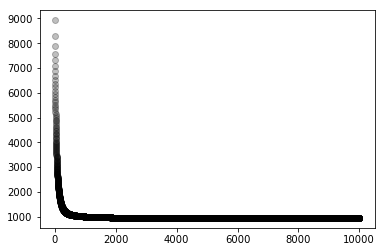

In [67]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [68]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

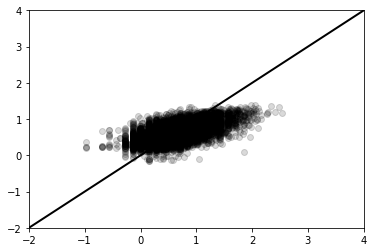

In [69]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 5.1: Validation Set Performance

In [70]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 313.1394
[torch.FloatTensor of size 1]

In [71]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

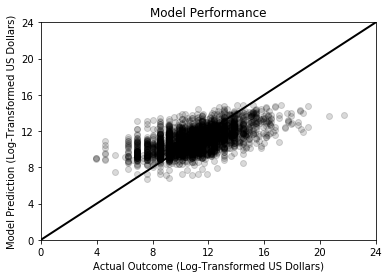

In [72]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [73]:
model[(0)].weight

Parameter containing:
 0.0068  0.1231  0.1477 -0.0295  0.0194  0.0039 -0.0324  0.0294  0.0093
[torch.FloatTensor of size 1x9]